Step $5$: refine the ROI image, in order to have as height the minimum height of a bar, and in order to be $10*X$ from the first and last bar. 

In [46]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils
import math
import matplotlib.patches as patches
import time

In [47]:
import importlib  

module = importlib.import_module('1) detect_roi')
detect_roi = module.detect_roi

module = importlib.import_module('2) rotate_image_boundingBox')
rotate_image_boundingBox = module.rotate_image_boundingBox

module = importlib.import_module('3) fix_horizontalBars_case')
fix_horizontalBars_case = module.fix_horizontalBars_case

module = importlib.import_module('4) compute_barcode_structure')
compute_barcode_structure = module.compute_barcode_structure

module = importlib.import_module('5) find_wrong_bar')
find_wrong_bar = module.find_wrong_bar

In [48]:
from os import listdir
from os.path import isfile, join
images_paths = [f for f in listdir('../images') if isfile(join('../images', f))]

In [49]:
image_path = f'../images/{images_paths[0]}'

(1200, 1600, 3)


Text(0.5, 1.0, 'Original image')

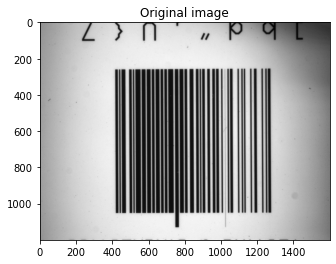

In [50]:
# load the image and convert it to grayscale
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(gray, 'gray')
plt.title('Original image')

array([[ 399.,  245.],
       [1290.,  241.],
       [ 403., 1071.],
       [1294., 1067.]], dtype=float32)

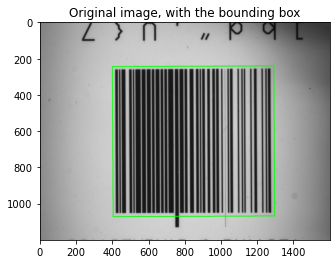

In [51]:
bb_points_sorted, bb_width, bb_height = detect_roi(image, visualize_bounding_box=True)
bb_points_sorted

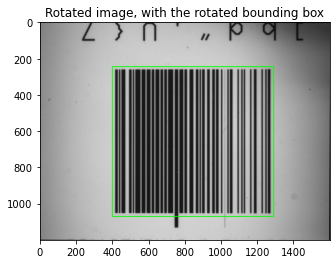

In [52]:
image_rot, bb_points_sorted_rot = rotate_image_boundingBox(image, bb_points_sorted, bb_width, bb_height, 
                                                           visualize_rot_image_bb=True)

In [53]:
image_rot, bb_points_sorted_rot, bb_width, bb_height = fix_horizontalBars_case(image_rot, bb_points_sorted_rot, bb_width, 
                                                                               bb_height, visualize_fixed_image_bb=True)

In [54]:
gray_rot = cv2.cvtColor(image_rot, cv2.COLOR_BGR2GRAY)
roi_image = gray_rot[int(bb_points_sorted_rot[0][1]):int(bb_points_sorted_rot[0][1]+bb_height), 
                             int(bb_points_sorted_rot[0][0]):int(bb_points_sorted_rot[0][0]+bb_width)]

Text(0.5, 1.0, 'ROI image')

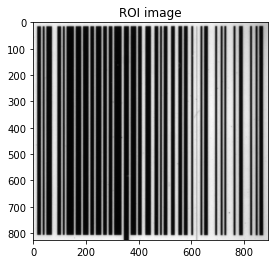

In [55]:
plt.figure()
plt.imshow(roi_image, 'gray')
plt.title('ROI image')

Time: 0.9546699523925781


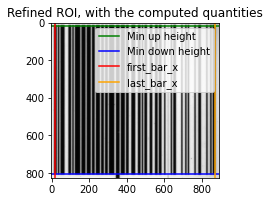

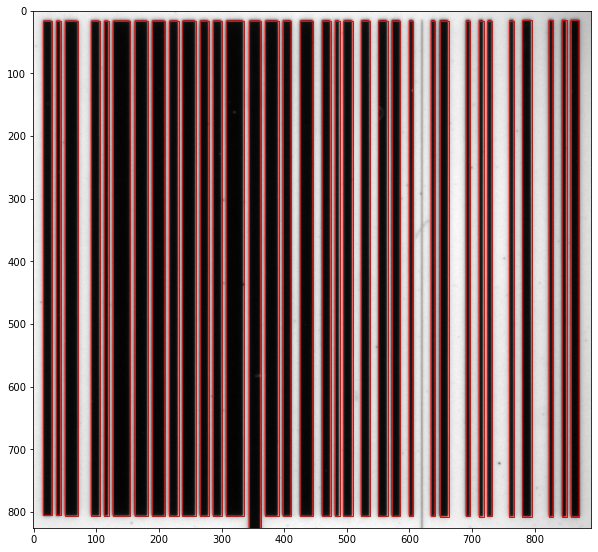

In [56]:
bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown = compute_barcode_structure(roi_image, bb_width, bb_height,
                                                                                           algorithm=4, verbose=True, 
                                                                                           visualize_refined_bb=True,
                                                                                           visualize_barcode_structure=True)

In [57]:
wrong_bar_index = find_wrong_bar(bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown, level=0.02)
wrong_bar_index

In [58]:
first_bar_x = min(bars_start)
last_bar_x = max([s+w for s,w in zip(bars_start,bars_width)])-1
X = min(bars_width)
min_half_height_up = min(bars_halfHeightUp)
min_half_height_down = min(bars_halfHeightDown)

half_height = math.ceil(bb_height/2)

In [59]:
if wrong_bar_index is not None:
    del bars_start[wrong_bar_index]
    del bars_width[wrong_bar_index]
    del bars_halfHeightUp[wrong_bar_index]
    del bars_halfHeightDown[wrong_bar_index]
    
    first_bar_x = min(bars_start)
    last_bar_x = max([s+w for s,w in zip(bars_start,bars_width)])-1
    X = min(bars_width)
    min_half_height_up = min(bars_halfHeightUp)
    min_half_height_down = min(bars_halfHeightDown)

    half_height = math.ceil(bb_height/2)
    
    plt.figure(figsize=(3, 3))
    plt.imshow(roi_image, 'gray')
    plt.axhline(half_height-min_half_height_up-1, c='green', label='Min up height')
    plt.axhline(half_height+min_half_height_down-1, c='blue', label='Min down height')
    plt.axvline(first_bar_x, c='red', label='first_bar_x')
    plt.axvline(last_bar_x, c='orange', label='last_bar_x')
    plt.title('Refined ROI, with the computed quantities')
    plt.legend()

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(roi_image, 'gray')
    n_bars = len(bars_start)
    for b in range(n_bars):
        # Create a Rectangle patch
        rect = patches.Rectangle((bars_start[b]-0.5, half_height-bars_halfHeightUp[b]-1-0.5), bars_width[b], 
                                 bars_halfHeightUp[b]+bars_halfHeightDown[b]+1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.show()
    ax.set_title('Exaustive barcode structure')

## COMPUTE THE REFINED (AND ROTATED) BOUNDING BOX
Refine along the width: $10*X$ and $-10*X$. 

In [60]:
bb_points_sorted_rot_ref = bb_points_sorted_rot.copy()
bb_points_sorted_rot_ref[[0,2],0] = bb_points_sorted_rot[[0,2],0] - (10*X-first_bar_x) 
bb_points_sorted_rot_ref[[1,3],0] = bb_points_sorted_rot[[1,3],0] + (10*X-(bb_width-last_bar_x-1))

## VISUALIZATION

In [61]:
def sort_bb_points_for_visualization(bb_points_sorted):
    """Function which sorts the bb points differently, for making the bb compliant with the visualization API"""
    bb_rot = bb_points_sorted.copy()
    bb_rot[2, :] = bb_points_sorted[3, :]
    bb_rot[3, :] = bb_points_sorted[2, :]
    return bb_rot.astype(int)

Text(0.5, 1.0, 'Refined bounding box')

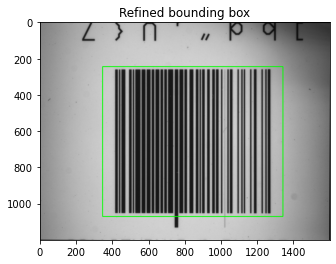

In [62]:
image_rot_bb = image_rot.copy()
cv2.drawContours(image_rot_bb, [sort_bb_points_for_visualization(bb_points_sorted_rot_ref)], -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(image_rot_bb, 'gray')
plt.title('Refined bounding box')

Text(0.5, 1.0, 'Refined ROI')

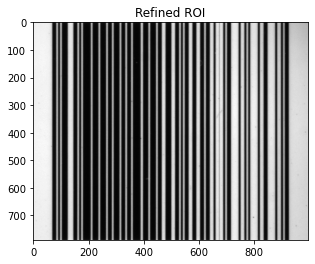

In [63]:
roi_image_ref = gray_rot[int(bb_points_sorted_rot_ref[0][1]):int(bb_points_sorted_rot_ref[2][1])+1, int(bb_points_sorted_rot_ref[0][0]):int(bb_points_sorted_rot_ref[1][0])+1]
roi_image_ref = roi_image_ref[half_height-min_half_height_up-1:half_height+min_half_height_down-1,:]
plt.figure()
plt.imshow(roi_image_ref, 'gray')
plt.title('Refined ROI')

In [64]:
new_bb_height, new_bb_width  = roi_image_ref.shape
new_half_height = math.ceil(new_bb_height/2)

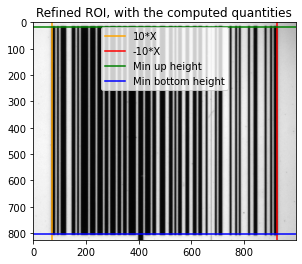

In [65]:
roi_image_ref_show = gray_rot[int(bb_points_sorted_rot_ref[0][1]):int(bb_points_sorted_rot_ref[2][1])+1, int(bb_points_sorted_rot_ref[0][0]):int(bb_points_sorted_rot_ref[1][0])+1].copy()
plt.figure()
plt.imshow(roi_image_ref_show, 'gray')
#plt.vlines([10*X,-10*X], ymin=0, ymax=new_bb_height,  label='10*X')
plt.axvline(10*X, c='orange', label='10*X')
plt.axvline(new_bb_width-10*X-1, c='red', label='-10*X')
plt.axhline(half_height-min_half_height_up-1, c='green', label='Min up height')
plt.axhline(half_height+min_half_height_down-1, c='blue', label='Min bottom height')
plt.title('Refined ROI, with the computed quantities')
plt.legend()

## CONCLUDE REFINEMENT OF THE BOUNDING BOX
Refinement of the bounding box along the height: `min_half_height_up` and `min_half_height_down`.

In [66]:
bb_points_sorted_rot_ref[[0,1],1] = bb_points_sorted_rot_ref[[0,1],1] + (half_height-1-min_half_height_up) 
bb_points_sorted_rot_ref[[2,3],1] = bb_points_sorted_rot_ref[[2,3],1] - (half_height-1-min_half_height_down)
if half_height%2==0:
   bb_points_sorted_rot_ref[[2,3],1] -= 1 

In [67]:
def sort_bb_points_for_visualization(bb_points_sorted):
    """Function which sorts the bb points differently, for making the bb compliant with the visualization API"""
    bb_rot = bb_points_sorted.copy()
    bb_rot[2, :] = bb_points_sorted[3, :]
    bb_rot[3, :] = bb_points_sorted[2, :]
    return bb_rot.astype(int)

Text(0.5, 1.0, 'Refined bounding box')

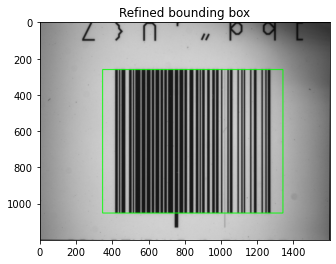

In [68]:
image_rot_bb = image_rot.copy()
cv2.drawContours(image_rot_bb, [sort_bb_points_for_visualization(bb_points_sorted_rot_ref)], -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(image_rot_bb, 'gray')
plt.title('Refined bounding box')

Text(0.5, 1.0, 'Refined ROI')

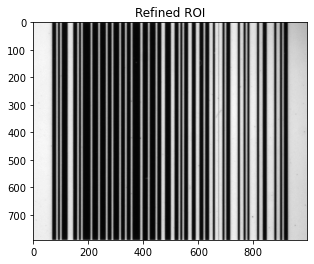

In [69]:
roi_image_ref = gray_rot[int(bb_points_sorted_rot_ref[0][1]):int(bb_points_sorted_rot_ref[2][1])+1, int(bb_points_sorted_rot_ref[0][0]):int(bb_points_sorted_rot_ref[1][0])+1]
plt.figure()
plt.imshow(roi_image_ref, 'gray')
plt.title('Refined ROI')